# Age prediction


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys

import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model

from utilities import montecarlo_crossvalidation
from utilities import model_optimization
from utilities import gridsearch_bias

In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldatasetclean.csv")
tsetse_data.head()

,Cat1,ID,Cat3,Cat4,Cat5,ID.1,4000,3998,3996,3994,...,420,418,416,414,412,410,408,406,404,402
0,PLATE1,1,f,3d,A,20230124,0.00973,0.00981,0.00995,0.00992,...,0.31585,0.31551,0.31425,0.31425,0.31251,0.31266,0.31364,0.31226,0.30996,0.30855
1,PLATE1,1,f,3d,H,20230124,0.00914,0.00906,0.00905,0.00912,...,0.33684,0.33738,0.33571,0.33571,0.33280,0.33054,0.32989,0.33004,0.33029,0.32963
2,PLATE1,1,f,3d,T,20230124,0.01765,0.01756,0.01765,0.01776,...,0.34662,0.34480,0.33926,0.33926,0.33376,0.33243,0.33413,0.33486,0.33583,0.33807
3,PLATE1,2,f,3d,A,20230124,0.01030,0.01029,0.01027,0.01024,...,0.17542,0.17600,0.17609,0.17609,0.17532,0.17393,0.17268,0.17255,0.17383,0.17489
4,PLATE1,2,f,3d,H,20230124,0.01099,0.01084,0.01083,0.01083,...,0.29031,0.28997,0.28927,0.28927,0.28751,0.28568,0.28370,0.28182,0.28138,0.28206


In [5]:

tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [6]:
tsetse_data_copy = tsetse_data.copy()

In [7]:
tsetse_females_thorax = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'f') & (tsetse_data_copy['Tissue'] == 'Thorax')]

tsetse_females_head = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'f') & (tsetse_data_copy['Tissue'] == 'Head')]

In [8]:
tsetse_females_thorax.groupby("Age")["ID"].count()

Age
3d    136
5w     96
7w    122
Name: ID, dtype: int64

In [9]:
tsetse_females_head.groupby("Age")["ID"].count()

Age
3d    133
5w     92
7w    120
Name: ID, dtype: int64

In [10]:
tsetse_females_thorax_copy = tsetse_females_thorax.copy()
tsetse_females_head_copy = tsetse_females_head.copy()

## Age prediction females

In [11]:
X_thorax = tsetse_females_thorax_copy.loc[:,"4000":"402"]
y_thorax = tsetse_females_thorax_copy.loc[:,"Age"]

X_head = tsetse_females_head_copy.loc[:,"4000":"402"]
y_head = tsetse_females_head_copy.loc[:,"Age"]

In [12]:
waveNumslist_reduced = X_thorax.columns.values.tolist()
wavenumbers_reduced = [int(x) for x in waveNumslist_reduced]

## Biased test

In [13]:
X_head_part1 = tsetse_females_head.loc[:,"4000":"402"]
X_head_part2 = tsetse_females_head.loc[:,"1800":"600"]
X_head_part3 = tsetse_females_head.loc[:,"3500":"2750"]
X_head_part4 = tsetse_females_head.loc[:,"2750":"1800"]

X_head_desbiased = pd.concat([X_head_part3,X_head_part2],axis=1)


y_head = tsetse_females_head.loc[:,"Age"]

In [14]:

bias_test_head_part1 = gridsearch_bias(X_head_part1, y_head)
bias_test_head_part2 = gridsearch_bias(X_head_part2, y_head)
bias_test_head_part3 = gridsearch_bias(X_head_part3, y_head)
bias_test_head_part4 = gridsearch_bias(X_head_part4, y_head)
bias_test_head_part5 = gridsearch_bias(X_head_desbiased, y_head)

In [15]:
result = pd.concat([bias_test_head_part1, 
    bias_test_head_part2['mean_test_score'],
    bias_test_head_part3['mean_test_score'],
    bias_test_head_part4['mean_test_score'],
    bias_test_head_part5['mean_test_score']], axis=1)

result["Tissue"] = "Head"

In [16]:
# Thorax

X_thorax_part1 = tsetse_females_thorax.loc[:,"4000":"402"]
X_thorax_part2 = tsetse_females_thorax.loc[:,"1800":"600"]
X_thorax_part3 = tsetse_females_thorax.loc[:,"3500":"2750"]
X_thorax_part4 = tsetse_females_thorax.loc[:,"2750":"1800"]

X_thorax_desbiased = pd.concat([X_thorax_part3,X_thorax_part2],axis=1)

y_thorax = tsetse_females_thorax.loc[:,"Age"]


In [17]:
# thorax
bias_test_part1 = gridsearch_bias(X_thorax_part1,y_thorax)
bias_test_part2 = gridsearch_bias(X_thorax_part2,y_thorax)
bias_test_part3 = gridsearch_bias(X_thorax_part3,y_thorax)
bias_test_part4 = gridsearch_bias(X_thorax_part4,y_thorax)
bias_test_part5 = gridsearch_bias(X_thorax_desbiased,y_thorax)

In [18]:
result2 = pd.concat([bias_test_part1, bias_test_part2['mean_test_score'],bias_test_part3['mean_test_score'],bias_test_part4['mean_test_score'],bias_test_part5['mean_test_score']], axis=1)
result2["Tissue"] = "Thorax"

In [19]:
bias_agemales = pd.concat([result2, result])
bias_agemales.set_index("Tissue", inplace=True)

bias_agemales.columns = ["Model", "kernel","D1","D2","D3","D4","D5"]
bias_agemales

bias_agemales.to_excel("../results/tables/wholespectra_results/biased_agefemales_pred.xlsx")

In [22]:
# permutation test

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

clf = LogisticRegression(max_iter=10000, random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, X_thorax, y_thorax, scoring="accuracy", cv=cv, n_permutations=1000)



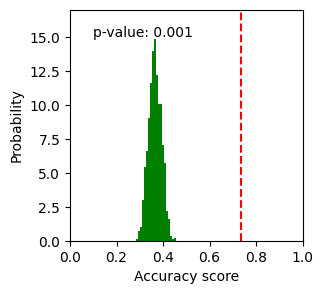

In [24]:
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(perm_scores_iris, bins=20, density=True,color='g')
ax.axvline(score_iris, ls="--", color="r")
score_label = f"p-value: {pvalue_iris:.3f}"
ax.text(0.1, 15, score_label, fontsize=10)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
ax.set_xlim(0,1)
ax.set_ylim(0,17)

plt.savefig("../results/plots/permutationtest_age_females.png", dpi=300, bbox_inches='tight')

# Age prediction females using the whole spectra

In [20]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [21]:
waveNumslist = X_head.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [22]:
shape_data = {"train_head": y_hd_train.value_counts(),
              "train_thorax": y_th_train.value_counts(),
              "test_head": y_hd_test.value_counts(),
              "test_thorax":y_th_test.value_counts()}
shape_data_df = pd.DataFrame(shape_data)

shape_data_df
shape_data_df.to_excel("../results/tables/wholespectra_results/train_test_shape_age_females.xlsx")


In [23]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [24]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

In [25]:
output=data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean', 'std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.669643  0.091151
1        LR  0.857143  0.044544
2        RF  0.742857  0.050648
3       SVC  0.757143  0.049943


In [26]:
output=data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean', 'std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.684211  0.068198
1        LR  0.915789  0.045898
2        RF  0.731579  0.074913
3       SVC  0.712281  0.066779


In [27]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [28]:
# thorax
best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [29]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [30]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.927536231884058
Accuracy on test set: 0.9295774647887324


In [31]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head["Tissue"] = "Head"
report_head

,precision,recall,f1-score,support,Tissue
3d,0.827586,1.000000,0.905660,24.000000,Head
5w,1.000000,0.894737,0.944444,19.000000,Head
7w,1.000000,0.884615,0.938776,26.000000,Head
accuracy,0.927536,0.927536,0.927536,0.927536,Head
macro avg,0.942529,0.926451,0.929627,69.000000,Head
weighted avg,0.940030,0.927536,0.928818,69.000000,Head


In [32]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax["Tissue"] = "Thorax"
report_thorax

,precision,recall,f1-score,support,Tissue
3d,0.954545,0.954545,0.954545,22.000000,Thorax
5w,0.956522,0.880000,0.916667,25.000000,Thorax
7w,0.884615,0.958333,0.920000,24.000000,Thorax
accuracy,0.929577,0.929577,0.929577,0.929577,Thorax
macro avg,0.931894,0.930960,0.930404,71.000000,Thorax
weighted avg,0.931603,0.929577,0.929531,71.000000,Thorax


In [33]:
report_agefemales_prediction = pd.concat([report_head, report_thorax])

report_agefemales_prediction.to_excel("../results/tables/wholespectra_results/Accuracy_agefemales_report.xlsx")

In [36]:
# monte carlo cross validation

accuracy_head_mc, sensitivity_head_mc, specificity_head_mc = montecarlo_crossvalidation(X_head, y_head, best_model_head, binary=False)

shuffle split:   0%|          | 0/100 [00:00<?, ?it/s]

shuffle split: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.90 ± 0.03


In [37]:
accuracy_thorax_mc, sensitivity_thorax_mc, specificity_thorax_mc = montecarlo_crossvalidation(X_thorax, y_thorax, best_mdoel_thorax, binary=False)

shuffle split: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.92 ± 0.03


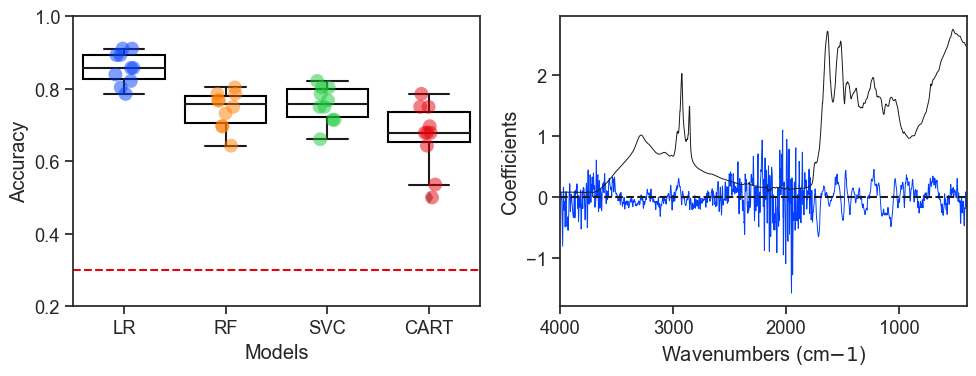

In [45]:
# coefficients

sn.set(font_scale=1.2)
sn.set_palette("bright", color_codes=True)
sn.set_style('ticks')

fig, (ax,ax2) = plt.subplots(1,2,figsize=(10,4), tight_layout=True)
coef = best_model_head['model'].coef_[0]

#boxplot
sn.boxplot(data=data_plot_head, x='param_clf', y='value', ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf', y='value', ax=ax, size=10, alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax.lines, color='k')
ax.axhline(0.3, ls='--', color='r')
for l, box in enumerate(ax.patches):
    box.set_edgecolor("black")

ax.set_ylabel("Accuracy")
ax.set_xlabel("Models")
ax.set_ylim(0.2,1)


#coefficients
sn.lineplot(x=wavenumbers_reduced, y=coef,ax=ax2, linewidth=0.7)
sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_head ,axis=0)*9),color='k',ax=ax2, linewidth=0.7)
ax2.axhline(0, ls="--", color='k')
ax2.set_xlim(4000, 400)
ax2.set_ylabel("Coefficients")
ax2.set_xlabel("Wavenumbers (cm${-1}$)")

plots1 = [ax,ax2]
letters = ["A", "B", "C", "D", "E", "F"]

#for p, t in zip(plots1, letters):
#    p.set_title(t, loc="left", weight='bold', fontsize=20)

plt.savefig("../results/plots/age_prediction_females_figure4.png", dpi=900)